In [1]:
from astropy.io import fits
import numpy as np
from astropy import units
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import os
from tqdm import tqdm
from astropy.table import Table
from astropy.time import Time
from astropy.wcs import WCS
import astropy
from scipy.signal import medfilt
from astropy.stats import sigma_clip
from astropy.timeseries import LombScargle

import warnings
warnings.filterwarnings("ignore")

from astropy.coordinates import SkyCoord

rc = Table.read('rcParams.txt', format='csv')
for name, val in zip(rc['name'], rc['value']):
    plt.rcParams[name] = val

In [2]:
pixels12 = np.load('pixels_1-2_3I_xlow-535_ylow-18_flipped.npy', allow_pickle=True).item()

locs12 = Table.read('/home/adina/.eleanor/ffis/s0092/locs_1-2.csv', format='csv')
locs12.sort('file')
_, u = np.unique(locs12['file'], return_index=True)
locs12 = locs12[u][280:]

In [3]:
data12  = pixels12['pixels'].reshape(pixels12['shape'])
model12 = pixels12['models'].reshape(pixels12['shape'])
time12  = pixels12['time'] + 0.0

xshift12 = locs12['x'] - pixels12['extent'][2]
yshift12 = locs12['y'] - pixels12['extent'][0]

In [94]:
size = 9
npixels = size*2+1

tpf12 = np.zeros((len(data12), size*2+1, size*2+1))
tpf12_sub = np.zeros((len(data12), size*2+1, size*2+1))
good  = np.zeros(len(data12))

for i in range(len(data12)):
    inty = int(xshift12[i])
    intx = int(yshift12[i])
    c = data12[i][intx-size:intx+size+1, inty-size:inty+size+1] + 0.0
    mask = sigma_clip(c, sigma=2)
    #c[mask.mask] = 0.0
    
    if len(np.where(mask.mask==True)[0]) > (npixels*npixels)/3.3:
        good[i] = 1

    tpf12[i] = c
    tpf12_sub[i] = c / model12[i][intx-size:intx+size+1, inty-size:inty+size+1]

In [134]:
np.save('stacked_3I_1-2.npy', {'raw':tpf12,
                               'subtracted':tpf12_sub,
                               'good_frames':good,
                               'time':time12,
                               'loc':[10,10]})

In [ ]:
np.save('stacked_3I_1-2_raw.npy', tpf12)

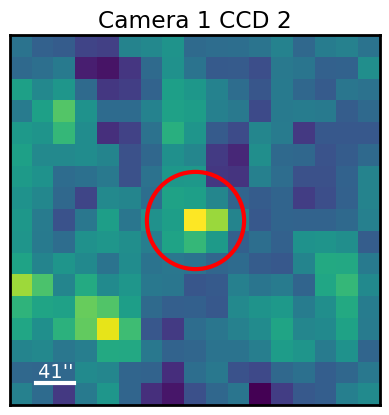

In [99]:
plt.imshow(np.nansum(tpf12_sub[good==1], axis=0)[2:,2:], origin='lower')
#plt.colorbar()
plt.plot(8,8,'ro', ms=70, color="none", markeredgecolor='r', markeredgewidth=3)
plt.xticks([])
plt.yticks([])
plt.title('Camera 1 CCD 2')

plt.axhline(0.5, 0.07, 0.172, color='w', zorder=10, lw=3)
plt.text(0.8, 0.8, "41''", color='w')

plt.xlim(-0.5, 16.5)
plt.ylim(-0.5, 16.5)

plt.savefig('3I_tess_stacked_cameraccd_12.pdf', bbox_inches='tight', dpi=300)

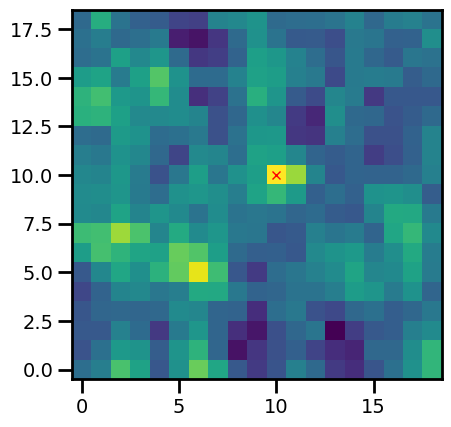

In [107]:
plt.imshow(np.nansum(tpf12_sub[good==1], axis=0), origin='lower')
plt.plot(10, 10, 'rx')

In [108]:
summed_tpf = np.nansum(tpf12[good==1], axis=0)
value = summed_tpf[10,10]

dur = (len(time12[good==1])*3*units.min).to(units.s).value

-2.5*np.log10(value/dur)+20.44

19.459968659709254

In [123]:
def convert_mag(counts, ):
    dur = (len(counts) * 200 * units.s)
    dur = dur.value
    return -2.5 * np.log10(counts/200) + 20.44

(21.0, 17.0)

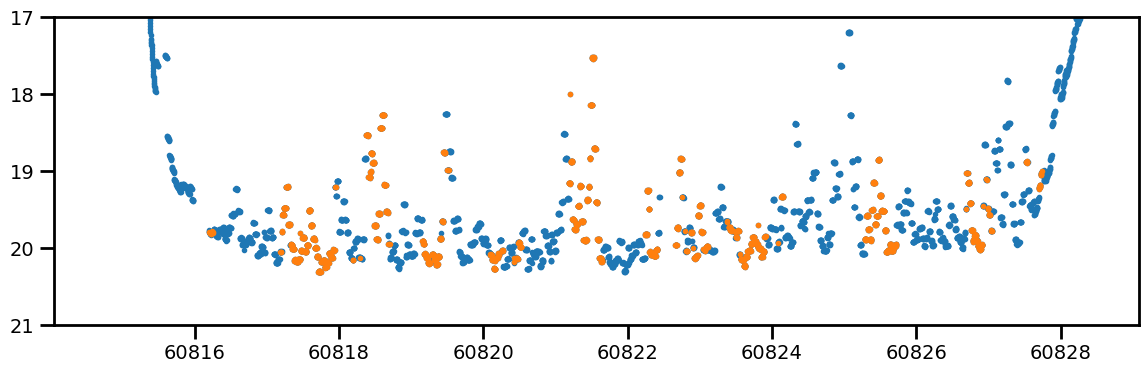

In [128]:
plt.figure(figsize=(14,4))
q = tpf12[:,10,10] > 0

mag_lc = convert_mag(tpf12[:,10,10])

plt.plot(time12, mag_lc, '.')

plt.plot(time12[good==1], mag_lc[good==1], '.')
plt.ylim(21, 17)

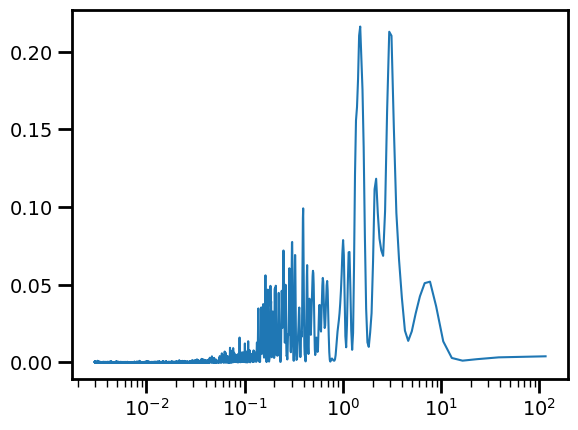

In [131]:
q = good==1#(time12 >= 60817) & (time12 <= 60827)
frequency, power = LombScargle(time12[q], mag_lc[q]).autopower()
plt.plot(1/frequency, power)
#plt.ylim(0, 0.01)
plt.xscale('log')